### ITD
En este dataset tenemos fotos tomadas con 10 cámaras diferentes a diferentes telas. De cada cámara tenemos una parte de las fotos para train, en las que solamente hay fotos de telas en buen estado. Y otra parte para test, en las que hay fotos de telas en buen estado y dañadas.
El objetivo es entrenar el modelo solo con las fotos de train (tela en buen estado) y poder predecir si una foto de test es una tela en buen estado ($y_{test}=0$) o dañada ($y_{test}=1$).

## Leer datos todos juntos

Leemos mezclando test y train, y luego particioanremos todos los datos en train, val y test

In [ ]:
import cv2
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

def cargar_dataset_imagenes(root_path, image_size=(64, 64)):
    """
    Lee las imágenes y las devuelve en formato (N, Alto, Ancho).
    NO aplana las imágenes. Mantiene la estructura espacial.
    """
    X_list = []
    y_list = []
    
    root = Path(root_path)
    print(f"📂 Escaneando imágenes en: {root.absolute()} ...")
    
    if not root.exists():
        print("❌ Error: La ruta no existe.")
        return np.array([]), np.array([])

    contador = 0
    
    for img_path in root.rglob('*.*'):
        if img_path.suffix.lower() not in ['.png', '.jpg', '.jpeg', '.bmp']:
            continue
            
        # --- 1. ETIQUETADO ---
        # 1 = Defecto (Anomaly), 0 = Bien (Good)
        label = 1 if 'anomaly' in str(img_path).lower() else 0
            
        # --- 2. LECTURA (Escala de Grises) ---
        # Leemos en blanco y negro para simplificar (1 canal). 
        # Si quisieras color, quita el flag IMREAD_GRAYSCALE.
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        
        if img is None: continue
        
        # --- 3. RESIZE (Obligatorio) ---
        # Todas deben medira entrar en el array numpy
        img = cv2.resize(img, image_size)
        
        # --- 4. NORMALIZACIÓN ---
        # Pasamos de 0-255 (enteros) a 0.0-1.0 (float).
        # Esto es vital tanto para ML clásico como para Deep Learning.
        img_norm = img.astype('float32') / 255.0
        
        X_list.append(img_norm)
        y_list.append(label)
        contador += 1

    # Convertimos la lista a un Array Numpy 3D: (N_fotos, Alto, Ancho)
    X_array = np.array(X_list)
    y_array = np.array(y_list)

    print(f"✅ Carga completa. {contador} imágenes procesadas.")
    return X_array, y_array

# --- EJECUCIÓN: CARGAR Y DIVIDIR ---

ruta = "./ITD" # Tu ruta
X_total, y_total = cargar_dataset_imagenes(ruta, image_size=(64, 64))

# Verificación de forma
# Debería salir algo como: (5000, 64, 64) -> 5000 fotos de 64x64
print(f"\nForma de X_total: {X_total.shape}") 

# --- PARTICIÓN (Train / Val / Test) ---
# 1. Separamos Train (70%) del resto (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_total, y_total, test_size=0.3, random_state=42, stratify=y_total
)

# 2. Separamos el resto en Val (15%) y Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("-" * 30)
print(f"🔹 Train shape: {X_train.shape} (Listo para Autoencoders/CNN)")
print(f"🔹 Val shape:   {X_val.shape}")
print(f"🔹 Test shape:  {X_test.shape}")
print("-" * 30)

# mostramos numero de anomalias en cada conjunto
print(f"Train anomalies: {np.sum(y_train)}")
print(f"Val anomalies:   {np.sum(y_val)}")
print(f"Test anomalies:  {np.sum(y_test)}")

📂 Escaneando imágenes en: c:\Users\ander\OneDrive - UPNA\4º\Extracción del conocimiento\TrabajoGrupo\ITD ...
✅ Carga completa. 5878 imágenes procesadas.

Forma de X_total: (5878, 64, 64)
------------------------------
🔹 Train shape: (4114, 64, 64) (Listo para Autoencoders/CNN)
🔹 Val shape:   (882, 64, 64)
🔹 Test shape:  (882, 64, 64)
------------------------------
Train anomalies: 675
Val anomalies:   145
Test anomalies:  145


Ahora la forma de leerlos de train (solo good) y test (good y anomaly) por separado:

In [ ]:
import cv2
import numpy as np
from pathlib import Path

def cargar_datos_separados_raw(root_path, image_size=(64, 64)):
    """
    Lee las carpetas originales 'train' y 'test' y devuelve los datos separados.
    Formato: RAW (Píxeles 2D, normalizados 0-1).
    """
    # Listas para Entrenamiento
    X_train = []
    y_train = []
    
    # Listas para Test
    X_test = []
    y_test = []
    
    root = Path(root_path)
    print(f"📂 Escaneando estructura original en: {root.absolute()} ...")
    
    if not root.exists():
        print("❌ Error: La ruta no existe.")
        return np.array([]), np.array([]), np.array([]), np.array([])

    contador_train = 0
    contador_test = 0
    
    for img_path in root.rglob('*.*'):
        if img_path.suffix.lower() not in ['.png', '.jpg', '.jpeg', '.bmp']:
            continue
        
        path_str = str(img_path).lower()
        
        # --- 1. IDENTIFICAR SPLIT (¿Es Train o Test?) ---
        if 'train' in path_str:
            is_train = True
        elif 'test' in path_str:
            is_train = False
        else:
            continue # Si no está en ninguna carpeta train/test, la ignoramos
            
        # --- 2. IDENTIFICAR ETIQUETA (¿Good o Anomaly?) ---
        # 1 = Defecto, 0 = Bien
        label = 1 if 'anomaly' in path_str else 0
        
        # --- 3. LEER RAW (Escala de Grises) ---
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        
        if img is None: continue
        
        # --- 4. RESIZE & NORMALIZACIÓN ---
        img = cv2.resize(img, image_size)
        img_norm = img.astype('float32') / 255.0
        
        # --- 5. GUARDAR DONDE TOQUE ---
        if is_train:
            X_train.append(img_norm)
            y_train.append(label)
            contador_train += 1
        else:
            X_test.append(img_norm)
            y_test.append(label)
            contador_test += 1

    # Convertir todo a Numpy Arrays
    X_train_arr = np.array(X_train)
    y_train_arr = np.array(y_train)
    X_test_arr = np.array(X_test)
    y_test_arr = np.array(y_test)

    print(f"✅ Carga finalizada.")
    print(f"   Train: {contador_train} imágenes.")
    print(f"   Test:  {contador_test} imágenes.")
    
    return X_train_arr, y_train_arr, X_test_arr, y_test_arr

# --- USO ---
ruta = "./ITD" # Asegúrate que es la ruta correcta
X_train, y_train, X_test, y_test = cargar_datos_separados_raw(ruta, image_size=(64, 64))

print("\n--- DIMENSIONES (RAW) ---")
# Debería salir (N, 64, 64) -> Datos 2D listos para lo que quieras
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")

🚀 Buscando el modelo que NO deje pasar anomalías (Max Recall)...
Params: 0.1, 100, 1.0 -> Recall Val: 6.90%
Params: 0.1, 100, 0.8 -> Recall Val: 6.21%
Params: 0.1, 200, 1.0 -> Recall Val: 6.21%
Params: 0.1, 200, 0.8 -> Recall Val: 6.90%
Params: 0.15, 100, 1.0 -> Recall Val: 8.28%
Params: 0.15, 100, 0.8 -> Recall Val: 8.97%
Params: 0.15, 200, 1.0 -> Recall Val: 8.28%
Params: 0.15, 200, 0.8 -> Recall Val: 10.34%
Params: 0.2, 100, 1.0 -> Recall Val: 37.24%
Params: 0.2, 100, 0.8 -> Recall Val: 9.66%
Params: 0.2, 200, 1.0 -> Recall Val: 10.34%
Params: 0.2, 200, 0.8 -> Recall Val: 11.72%
Params: 0.25, 100, 1.0 -> Recall Val: 40.00%
Params: 0.25, 100, 0.8 -> Recall Val: 40.69%
Params: 0.25, 200, 1.0 -> Recall Val: 40.00%
Params: 0.25, 200, 0.8 -> Recall Val: 11.72%
Params: 0.3, 100, 1.0 -> Recall Val: 42.07%
Params: 0.3, 100, 0.8 -> Recall Val: 42.07%
Params: 0.3, 200, 1.0 -> Recall Val: 42.76%
Params: 0.3, 200, 0.8 -> Recall Val: 42.76%
Params: 0.35, 100, 1.0 -> Recall Val: 44.83%
Params: 0.

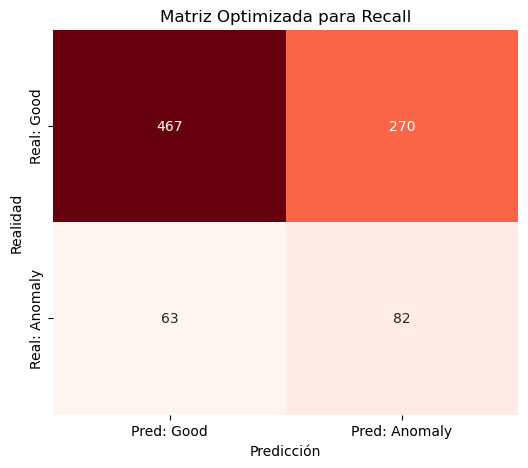

              precision    recall  f1-score   support

        Good       0.88      0.63      0.74       737
     Anomaly       0.23      0.57      0.33       145

    accuracy                           0.62       882
   macro avg       0.56      0.60      0.53       882
weighted avg       0.77      0.62      0.67       882


⚠️ DEJAMOS ESCAPAR: 63 de 145 defectos.


In [20]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. APLANAR SI ES NECESARIO ---
if len(X_train.shape) > 2:
    X_train_flat = X_train.reshape(len(X_train), -1)
    X_val_flat   = X_val.reshape(len(X_val), -1)
    X_test_flat  = X_test.reshape(len(X_test), -1)
else:
    X_train_flat, X_val_flat, X_test_flat = X_train, X_val, X_test

# --- 2. CONFIGURACIÓN ---
param_grid = {
    # Probamos contaminaciones más altas para forzar al modelo a detectar más
    'contamination': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], 
    'n_estimators': [100, 200],      
    'max_features': [1.0, 0.8]       
}

best_score = 0
best_params = {}
best_model = None

# --- 3. BUCLE DE BÚSQUEDA (OPTIMIZANDO RECALL) ---
print("🚀 Buscando el modelo que NO deje pasar anomalías (Max Recall)...")

for cont in param_grid['contamination']:
    for n_est in param_grid['n_estimators']:
        for max_feat in param_grid['max_features']:
            
            # Entrenar
            clf = IsolationForest(contamination=cont, 
                                  n_estimators=n_est, 
                                  max_features=max_feat,
                                  random_state=42, 
                                  n_jobs=-1)
            clf.fit(X_train_flat)
            
            # Evaluar en VAL
            preds_raw = clf.predict(X_val_flat)
            preds_val = [1 if x == -1 else 0 for x in preds_raw]
            
            # --- CAMBIO CLAVE: USAMOS RECALL ---
            # Nos da igual la precisión, queremos cazar todas las anomalías
            current_recall = recall_score(y_val, preds_val, pos_label=1)
            
            # Si el recall es mejor, guardamos este modelo
            if current_recall > best_score:
                best_score = current_recall
                best_params = {'contamination': cont, 'n_estimators': n_est, 'max_features': max_feat}
                best_model = clf
            
            print(f"Params: {cont}, {n_est}, {max_feat} -> Recall Val: {current_recall:.2%}")

print("-" * 40)
print(f"🏆 MEJOR MODELO (Maximizando Recall)")
print(f"   Parámetros: {best_params}")
print(f"   Recall en Val: {best_score:.2%}")
print("-" * 40)

# --- 4. PRUEBA DE FUEGO EN TEST ---
if best_model:
    print("\n📝 Resultados finales en TEST:")
    preds_test_raw = best_model.predict(X_test_flat)
    preds_test = [1 if x == -1 else 0 for x in preds_test_raw]
    
    # Matriz
    cm = confusion_matrix(y_test, preds_test)
    
    plt.figure(figsize=(6, 5))
    # Usamos mapa de color rojo para enfatizar el peligro de los fallos
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
                xticklabels=['Pred: Good', 'Pred: Anomaly'],
                yticklabels=['Real: Good', 'Real: Anomaly'])
    plt.ylabel('Realidad')
    plt.xlabel('Predicción')
    plt.title('Matriz Optimizada para Recall')
    plt.show()
    
    # Métricas
    print(classification_report(y_test, preds_test, target_names=['Good', 'Anomaly']))
    
    # Dato clave para ti
    fallos_graves = cm[1, 0] # Anomalías que el modelo dijo que eran buenas
    total_anomalias = cm[1, 0] + cm[1, 1]
    print(f"\n⚠️ DEJAMOS ESCAPAR: {fallos_graves} de {total_anomalias} defectos.")

## Random Forest

Aplanando datos para Random Forest...
Entrenando con 4114 muestras y 4096 características.
🚀 Iniciando búsqueda de hiperparámetros (esto puede tardar unos minutos)...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

🏆 MEJOR MODELO ENCONTRADO
   Parámetros: {'class_weight': {0: 1, 1: 20}, 'max_depth': 20, 'n_estimators': 100}
   Recall en Validación (CV): 51.26%

📝 Evaluando en el Test Set...


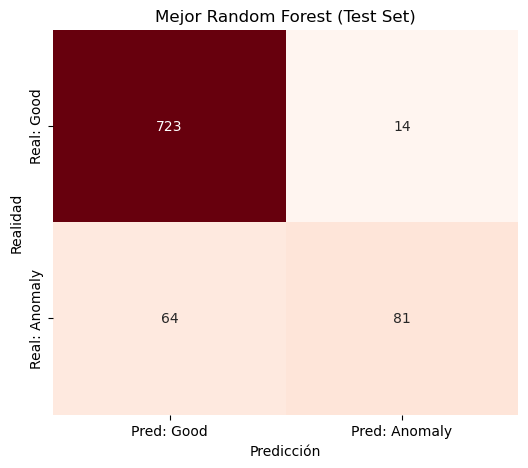

              precision    recall  f1-score   support

        Good       0.92      0.98      0.95       737
     Anomaly       0.85      0.56      0.68       145

    accuracy                           0.91       882
   macro avg       0.89      0.77      0.81       882
weighted avg       0.91      0.91      0.90       882


🔍 RESUMEN FINAL:
De 145 telas defectuosas, el modelo atrapó 81.
Se escaparon 64 defectos.
❌ Todavía se escapan demasiados defectos. Necesitamos Deep Learning.


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. APLANAR DATOS (Si no están planos ya) ---
# Random Forest necesita matriz 2D
if len(X_train.shape) > 2:
    print("Aplanando datos para Random Forest...")
    X_train_flat = X_train.reshape(len(X_train), -1)
    X_test_flat  = X_test.reshape(len(X_test), -1)
else:
    X_train_flat, X_test_flat = X_train, X_test

print(f"Entrenando con {X_train_flat.shape[0]} muestras y {X_train_flat.shape[1]} características.")

# --- 2. DEFINIR LA REJILLA DE PARÁMETROS ---
param_grid = {
    # Número de árboles
    'n_estimators': [100, 200],
    
    # Profundidad máxima (None = crece hasta el final, números = poda el árbol)
    'max_depth': [None, 20, 50],
    
    # PESOS: Aquí está la clave.
    # 'balanced': Ajusta pesos inversamente proporcionales a las frecuencias.
    # {0: 1, 1: 10}: Un error en Anomaly(1) cuesta 10 veces más que en Good(0).
    # {0: 1, 1: 20}: Un error en Anomaly(1) cuesta 20 veces más (Muy agresivo).
    'class_weight': ['balanced', {0: 1, 1: 10}, {0: 1, 1: 20}]
}

# --- 3. CONFIGURAR EL GRID SEARCH ---
print("🚀 Iniciando búsqueda de hiperparámetros (esto puede tardar unos minutos)...")

# Usamos scoring='recall' para que elija el modelo que mejor detecta anomalías
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='recall', # <--- OPTIMIZAMOS PARA RECALL (Sensibilidad)
    cv=3,             # Cross-Validation de 3 pliegues
    n_jobs=-1,        # Usar todos los núcleos
    verbose=2         # Para ver el progreso
)

# Entrenamos con el set de Train
grid_search.fit(X_train_flat, y_train)

# --- 4. RESULTADOS DEL GRID SEARCH ---
best_rf = grid_search.best_estimator_
print("\n" + "="*40)
print(f"🏆 MEJOR MODELO ENCONTRADO")
print(f"   Parámetros: {grid_search.best_params_}")
print(f"   Recall en Validación (CV): {grid_search.best_score_:.2%}")
print("="*40)

# --- 5. EVALUACIÓN FINAL EN TEST ---
print("\n📝 Evaluando en el Test Set...")

preds = best_rf.predict(X_test_flat)

# Matriz de Confusión
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=['Pred: Good', 'Pred: Anomaly'],
            yticklabels=['Real: Good', 'Real: Anomaly'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Mejor Random Forest (Test Set)')
plt.show()

# Reporte
print(classification_report(y_test, preds, target_names=['Good', 'Anomaly']))

# Análisis de fallos
fallos_graves = cm[1, 0] # Anomalías reales que predijo como Good
total_defectos = cm[1, 0] + cm[1, 1]

print(f"\n🔍 RESUMEN FINAL:")
print(f"De {total_defectos} telas defectuosas, el modelo atrapó {cm[1, 1]}.")
print(f"Se escaparon {fallos_graves} defectos.")

if fallos_graves == 0:
    print("✅ ¡PERFECTO! Recall del 100%.")
elif fallos_graves < total_defectos * 0.05:
    print("⚠️ Resultado muy bueno (menos del 5% de fugas).")
else:
    print("❌ Todavía se escapan demasiados defectos. Necesitamos Deep Learning.")